In [2]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import rasterio as rio

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy
import itertools
import random
import ast

## Data prep

In [23]:
# Open img-scout dfs

data_dir = '/Users/kathleenkanaley/Desktop/grapes_from_space/data/'
data_20 = pd.read_csv(data_dir +'img_scout_dfs/2020/smr_vis_skysat_scout_2020.csv').dropna()
data_21 = pd.read_csv(data_dir +'img_scout_dfs/2021/smr_vis_skysat_scout_2021.csv').dropna()
data_22 = pd.read_csv(data_dir +'img_scout_dfs/2022/smr_vis_skysat_scout_2022.csv').dropna()

data_21 = data_21[data_21['Date']!='2021-08-03']
data_20 = data_20[data_20['Date']!='2020-09-09']

img_dfs = [data_20, data_21, data_22]
#all_years = pd.concat(img_dfs)

In [25]:
prepped_dfs = []
for df in img_dfs:
    df = df.rename(columns={"green_red": "grvi"})
    
    # Create binary numeric label
    # 0 = low GDM
    # 1 = high GDM

    df['GDM_sev']=0
    df.loc[df['DM_severity'] > 10, 'GDM_sev'] =1
    
    df['GDM_inc']=0
    df.loc[df['DM_inc'] > 25, 'GDM_inc'] = 1
    prepped_dfs.append(df)

In [27]:
prepped_dfs[2].Date.unique()

array(['2022-06-22', '2022-07-06', '2022-07-20'], dtype=object)

In [30]:
# set up variables
data_2022 = prepped_dfs[2]
data_2021 = prepped_dfs[1]
data_2020 = prepped_dfs[0]
#data_all = pd.concat([data_2020,data_2021,data_2022])
#sev = 'severity_class'
inc = 'GDM_inc'
sbs = ['blue','green','red','nir']


In [31]:
def bal_split_norm(data, expl_vars, resp_var, state, seed):
    X = data[expl_vars]
    y = data[resp_var]

    rus = RandomUnderSampler(random_state=state)
    X_rus, y_rus = rus.fit_resample(X, y)

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                        test_size=0.3, 
                                                        random_state=seed,
                                                        stratify = y_rus)  # 70% training and 30% test
    mm = MinMaxScaler()
    X_train_scaled = mm.fit_transform(X_train)
    X_test_scaled = mm.transform(X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

In [32]:
# training data

Xtrain_2yr,ytrain_2yr,Xtest_2yr,ytest_2yr = bal_split_norm(pd.concat([data_2020,data_2021]),sbs,inc,2020,14)

In [8]:
# training data

# Xtrain_2020,ytrain_2020,Xtest_2020,ytest_2020 = bal_split_norm(data_2020,sbs,inc,2020,14)


# Xtrain_2021,ytrain_2021,Xtest_2021,ytest_2021 = bal_split_norm(data_2021,sbs,inc,2021,14)


# Xtrain_2022,ytrain_2022,Xtest_2022,ytest_2022 = bal_split_norm(data_2022,sbs,inc,2022,14)

In [9]:
# # training data

# Xtrain_2020,ytrain_2020 = data_prep(data_2020,sbs,inc,2020,14)


# Xtrain_2021,ytrain_2021 = data_prep(data_2021,sbs,inc,2021,14)


# Xtrain_2022,ytrain_2022 = data_prep(data_2022,sbs,inc,2022,14)

In [33]:
# testing data

mm=MinMaxScaler()

Xtest_2020all = mm.fit_transform(data_2020[sbs])
ytest_2020all = data_2020[inc].to_numpy().reshape(-1, 1)

Xtest_2021all = mm.fit_transform(data_2021[sbs])
ytest_2021all = data_2021[inc].to_numpy().reshape(-1, 1)

Xtest_2022all = mm.fit_transform(data_2022[sbs])
ytest_2022all = data_2022[inc].to_numpy().reshape(-1, 1)

In [34]:
# hyperparams

hp_2020 = {'bootstrap': True,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 34,
 'n_estimators': 200}

hp_2021 = {'bootstrap': True,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 18,
 'n_estimators': 100}

hp_2022 = {'bootstrap': True,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

hp_all = {'bootstrap': True,
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 18,
 'n_estimators': 300}

[[278 416]
 [  5  21]]
              precision    recall  f1-score   support

           0       0.98      0.40      0.57       694
           1       0.05      0.81      0.09        26

    accuracy                           0.42       720
   macro avg       0.52      0.60      0.33       720
weighted avg       0.95      0.42      0.55       720



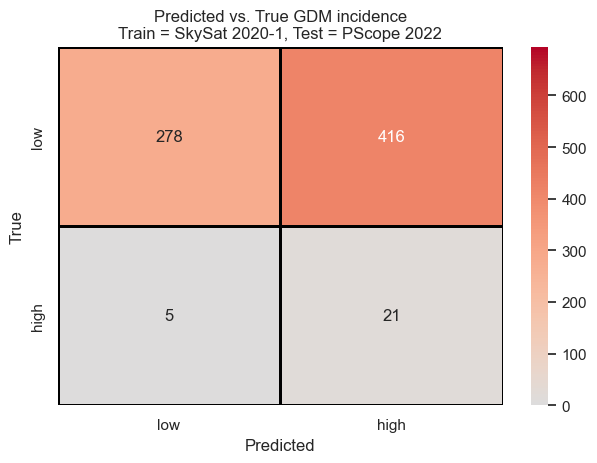

In [36]:
# train classifier on 2 years of data (2020 + 2021)

rfc_2yr = RandomForestClassifier().set_params(**hp_all)

rfc_2yr.fit(Xtrain_2yr, ytrain_2yr)

# predict on the 2022 images (test set)

ypredict_2022all = rfc_2yr.predict(Xtest_2022all)

cf_matrix = confusion_matrix(ytest_2022all, ypredict_2022all)
print(cf_matrix)

sns.set(font_scale=1)
sns.heatmap(cf_matrix, annot=True, fmt='.4g',
           vmin=0, vmax=694, center= 0,
           cmap= 'coolwarm', linewidths=2, linecolor='black', 
           #cbar_kws={'ticks':[0,1,2,3]},
           xticklabels=['low','high'],
           yticklabels=['low','high']).set(title='Predicted vs. True GDM incidence\nTrain = SkySat 2020-1, Test = PScope 2022');

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()

#plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/PScope/SB/Inc_2022.jpg')
report = classification_report(ytest_2022all, ypredict_2022all)

print(report)

In [37]:
# apply 2yr model to individual images from 2022


dates_2022 = data_2022.Date.unique()

imgdfs_2022 = []
for date in dates_2022:
    single_day = data_2022[data_2022['Date']==date]
    imgdfs_2022.append(single_day)
    
len(imgdfs_2022)

3

In [38]:
# Run model on indiv. images and save results as column in image dataframes

rfc_2yr = RandomForestClassifier().set_params(**hp_all)

rfc_2yr.fit(Xtrain_2yr, ytrain_2yr)

for df in imgdfs_2022:
    
    X = df[sbs]
    y = df[sev]

    mm = MinMaxScaler()
    X_scaled = mm.fit_transform(X)

    y_pred = rfc_2yr.predict(X_scaled)

    df['GDMInc_pred'] = y_pred.tolist()

/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_6669/3731303899.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GDMInc_pred'] = y_pred.tolist()
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_6669/3731303899.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GDMInc_pred'] = y_pred.tolist()
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_6669/3731303899.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [41]:
imgdfs_2022[2]

,acquired,plot,blue,green,red,nir,veg_smr,savi_exp,savi,msavi,...,PM_severity,DM_severity,total_dis,geometry,centroid,DM_inc,PM_inc,GDM_sev,GDM_inc,GDMInc_pred
480,20220720,1,0.033638,0.063963,0.069991,0.376206,0.703457,0.535700,0.485240,0.363167,...,1.60,0.000,3.500,POLYGON ((-77.0152645742787 42.878300949250196...,POINT (-77.0153084903025 42.8783140936145),5.0,25.0,0,0,1
481,20220720,2,0.035848,0.067241,0.074390,0.348141,0.622398,0.471872,0.445068,0.300047,...,5.60,0.000,6.300,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654),5.0,65.0,0,0,0
482,20220720,3,0.037370,0.067243,0.074120,0.354467,0.635918,0.482866,0.452837,0.312626,...,0.80,0.000,1.350,POLYGON ((-77.01544069426711 42.87833411925217...,POINT (-77.01548247530272 42.87834674861851),5.0,40.0,0,0,0
483,20220720,4,0.033990,0.063280,0.065883,0.360820,0.679317,0.521641,0.477357,0.340460,...,6.90,0.000,6.950,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055),5.0,80.0,0,0,1
484,20220720,5,0.031597,0.061762,0.062741,0.369890,0.712162,0.549340,0.494004,0.364410,...,3.65,0.000,3.650,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546),5.0,80.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,20220720,311,0.033967,0.062293,0.062013,0.341230,0.645378,0.499179,0.463628,0.309517,...,3.80,0.000,3.800,POLYGON ((-77.01605814333348 42.87891530908846...,POINT (-77.01609963030329 42.87892805863273),5.0,75.0,0,0,0
716,20220720,313,0.033807,0.063863,0.061587,0.366673,0.702761,0.545713,0.492968,0.360296,...,0.25,0.200,0.750,POLYGON ((-77.01588341334502 42.87888258908652...,POINT (-77.0159263203032 42.87889522862877),5.0,10.0,0,0,1
717,20220720,315,0.033431,0.060445,0.059738,0.363900,0.705711,0.548825,0.493944,0.358496,...,2.75,0.575,3.425,POLYGON ((-77.01571565335605 42.87885039908464...,POINT (-77.01575419030297 42.87886252362478),5.0,90.0,0,0,1
718,20220720,317,0.028686,0.053783,0.050524,0.372124,0.760645,0.602338,0.522732,0.393833,...,0.40,0.000,0.450,POLYGON ((-77.01554440336733 42.87881855908271...,POINT (-77.01558717530287 42.87883104862095),5.0,35.0,0,0,0


In [42]:
# get metrics

for df in imgdfs_2022:
    print(f"classification metrics for {df.Date.unique()}:\n")
    
    report = classification_report(df['GDM_inc'], df['GDMInc_pred'])
    print(report)

classification metrics for ['2022-06-22']:

              precision    recall  f1-score   support

           0       1.00      0.33      0.49       239
           1       0.01      1.00      0.01         1

    accuracy                           0.33       240
   macro avg       0.50      0.66      0.25       240
weighted avg       1.00      0.33      0.49       240

classification metrics for ['2022-07-06']:

              precision    recall  f1-score   support

           0       0.97      0.25      0.40       228
           1       0.06      0.83      0.10        12

    accuracy                           0.28       240
   macro avg       0.51      0.54      0.25       240
weighted avg       0.92      0.28      0.38       240

classification metrics for ['2022-07-20']:

              precision    recall  f1-score   support

           0       1.00      0.15      0.26       227
           1       0.06      1.00      0.12        13

    accuracy                           0.20       

In [43]:
# save .csvs

jun22 = imgdfs_2022[0]
jul06 = imgdfs_2022[1]
jul20 = imgdfs_2022[2]

jun22.to_csv('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/skysat_RFpred_20220622.csv', index=False)
jul06.to_csv('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/skysat_RFpred_20220706.csv', index=False)
jul20.to_csv('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/skysat_RFpred_20220720.csv', index=False)